# 1. Algorithme pour les graphes à poids avec contrainte de longueur

In [38]:
%run ../code_python/Algo_poids_long_v1.py

## 1.1. Preprocessing

In [2]:
def Preprocessing_Graph_poids_long_v1(G,epsilon = 0.5):
    """ Renvoie un tuple (dags, liste_bornes_distance_asc, listes_depart_distance_asc, nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs avec source i avec la somme partielle en 2eme coordonnée
        dags[depart][i][1] = dags[depart][i-1][1] + nb de ePCC (depart)-->(dags[depart][i])
        - liste_bornes_distance_asc = liste des (dep, arr, dist(dep,arr), nb ePCC (dep) -> (arr) en somme partielle) ordonnées par dist(dep,arr) croissant
        - listes_depart_distance_asc[depart] = liste des (arr, dist(depart,arr), nb ePCC (depart) -> (arr) en somme partielle) ordonnées par dist(depart,arr) croissant """

    n = len(G)
    tables = np.zeros((n,n))
    dags = []
    liste_bornes_distance_asc = []
    listes_depart_distance_asc = []

    poids = nx.get_edge_attributes(G,"length")

    for source in range(n):
        dist = Dijkstra_dist(G,source)
        Table_ePCC_In_Place(G,dist,poids,tables,source,epsilon)
        selected_edges = Selected_edges(G,dist,poids,epsilon)
        dag_pred = Construct_DAG(G,selected_edges,tables,source)
        dags.append(dag_pred)

        liste_source = []
        for arrivee in dist:
            liste_source.append((arrivee, dist[arrivee], tables[source][arrivee]))
            liste_bornes_distance_asc.append((source, arrivee, dist[arrivee], tables[source][arrivee]))

        # On ordonne par distance croissante
        liste_source = sorted(liste_source, key= lambda x : x[1])

        # On met les sommes partielles
        nb_ePCC_courant = 0
        for i in range(len(liste_source)):
            arrivee, distance, nb_ePCC = liste_source[i]
            liste_source[i] = (arrivee, distance, nb_ePCC + nb_ePCC_courant)
            nb_ePCC_courant += nb_ePCC

        listes_depart_distance_asc.append(liste_source)


    # On ordonne par distance croissante
    liste_bornes_distance_asc = sorted(liste_bornes_distance_asc, key= lambda x : x[2])

    # On met les sommes partielles
    nb_ePCC_courant = 0
    for i in range(len(liste_bornes_distance_asc)):
        depart, arrivee, distance, nb_ePCC = liste_bornes_distance_asc[i]
        liste_bornes_distance_asc[i] = (depart, arrivee, distance, nb_ePCC + nb_ePCC_courant)
        nb_ePCC_courant += nb_ePCC

    nb_chemins = int(nb_ePCC_courant)

    return (dags, liste_bornes_distance_asc, listes_depart_distance_asc, nb_chemins)

In [8]:
Cabourg = loadVille("cabourg")
len(Cabourg)

372

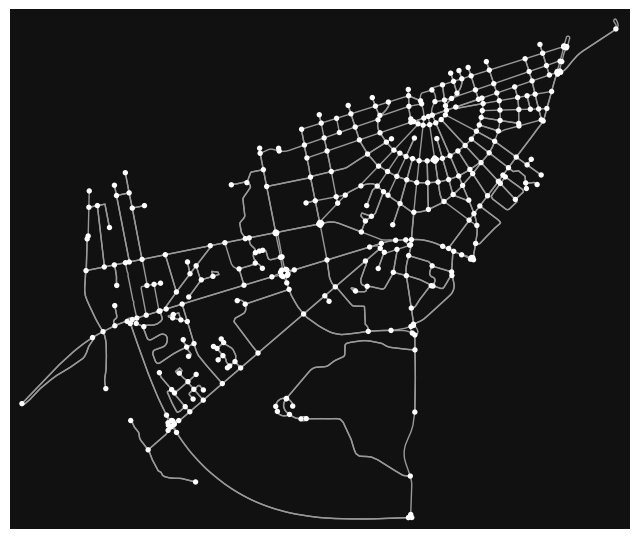

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [44]:
ox.plot_graph(Cabourg)

In [9]:
cabourg = Preprocessing_Graph_poids_long_v1(Cabourg)

In [23]:
# liste_bornes_distance_asc = liste des (dep, arr, dist(dep,arr), nb ePCC (dep) -> (arr) en somme partielle)
# ordonnées par dist(dep,arr) croissant

cabourg[1][60000:60005]

[(287, 194, 1119.296, 141893.0),
 (259, 227, 1119.3119999999997, 141895.0),
 (227, 259, 1119.3120000000001, 141897.0),
 (290, 108, 1119.326, 141903.0),
 (362, 142, 1119.3380000000002, 141913.0)]

In [30]:
# listes_depart_distance_asc[depart] = liste des (arr, dist(depart,arr), nb ePCC (depart) -> (arr) en somme partielle)
# ordonnées par dist(depart,arr) croissant

depart = 0
cabourg[2][depart][250:255]

[(149, 2119.54, 370.0),
 (199, 2123.7590000000005, 374.0),
 (109, 2127.4810000000007, 375.0),
 (331, 2130.4960000000005, 377.0),
 (108, 2137.5650000000005, 381.0)]

## 1.2. Générateur

In [40]:
def Uniforme_ePCC_long_v1(preprocessing,l_min = 0,l_max = -1):
    """ Renvoie un epsilon plus court chemin de G entre deux noeuds à distance d € ]l1, l2] avec probabilité uniforme """
    liste_bornes_distance_asc = preprocessing[1]
    longueur_plus_long_pcc = liste_bornes_distance_asc[-1][2]

    if (l_max<0):
        l_max = longueur_plus_long_pcc

    # On regarde les coordonnées des rangs qui respectent les critères de longueur
    i_min = recherche_dicho_par_coordonnee_sup(liste_bornes_distance_asc, l_min, 2) #liste_bornes_distance_asc[i_min][2] <= l_min < liste_bornes_distance_asc[i_min+1][2]
    i_max = recherche_dicho_par_coordonnee_sup(liste_bornes_distance_asc, l_max, 2) #liste_bornes_distance_asc[i_max][2] <= l_max < liste_bornes_distance_asc[i_max+1][2]

    rang = r.randint(0,liste_bornes_distance_asc[i_max][3]-1) if i_min == -1 else r.randint(liste_bornes_distance_asc[i_min][3], liste_bornes_distance_asc[i_max][3]-1)


    # On trouve les bornes associées à ce rang
    i = recherche_dicho_par_coordonnee_inf(liste_bornes_distance_asc, rang, 3)      #liste_bornes_distance_asc[i - 1][3] <= rang < liste_bornes_distance_asc[i][3]
    depart, arrivee, distance, nb_ePCC = liste_bornes_distance_asc[i]

    rang_reduit = rang - liste_bornes_distance_asc[i - 1][-1] if i > 0 else rang

    return Unranking_ePCC_depart_arrivee_long_v1(preprocessing, depart, arrivee, rang_reduit)

- Trouver i,j tels que bornes[i:j] correspondent à l'intervalle de longeur [L_min, L_max]
- Tirer un rang entre 1 et le nombre de ePCC entre deux noeuds à distance L € [L_min, L_max]
- Trouver les bornes de l'ePCC associé à ce rang
- Reconstruire le chemin

In [51]:
chemin = Uniforme_ePCC_long_v1(cabourg,l_min = 1000, l_max = 4000)
mesure_chemin(Cabourg,chemin)

2978.1969999999997

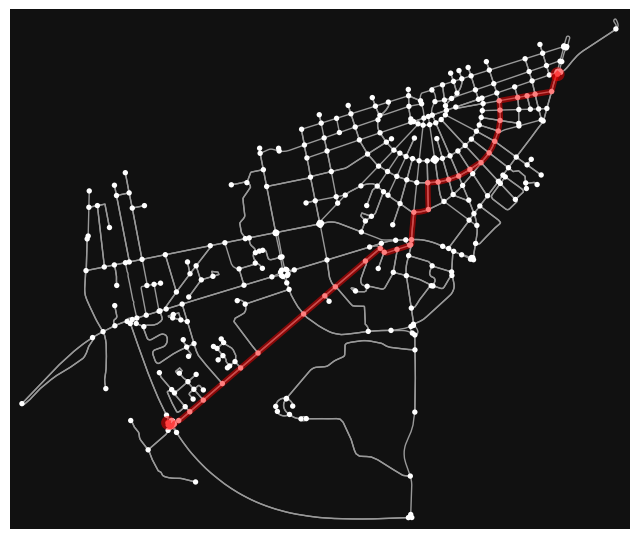

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [52]:
ox.plot_graph_route(Cabourg,chemin)

## 1.3. Complexité

In [53]:
%run ../code_python/Complexite_operations.py

In [54]:
echant_ER = echantillon_erdos_renyi()

In [55]:
data_ER_poids = calcul_donnees(c_Preprocessing_Graph_poids_v1, c_Uniforme_ePCC_v1, echant_ER)
data_ER_poids_long = calcul_donnees(c_Preprocessing_Graph_poids_long_v1, c_Uniforme_ePCC_long_v1, echant_ER)

In [56]:
data = [data_ER_poids, data_ER_poids_long]

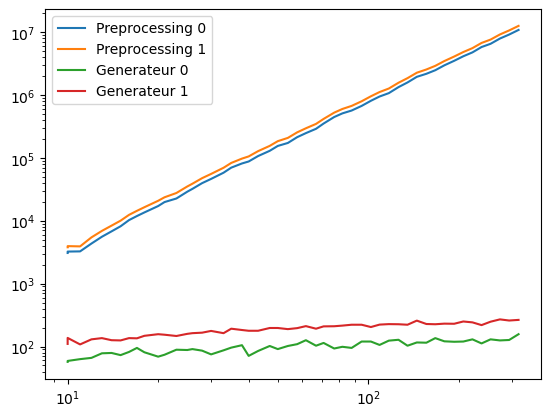

In [57]:
complexite_comparaison_donnees(data)

# 2. Distance moyenne VS Longueur moyenne PCC

## 2.1. Erdös-Renyi

In [72]:
%run ../code_python/comparaison_distance_longueur_moyenne.py

In [60]:
echant_ER = echantillon_erdos_renyi()
data_ER = calcul_longueur_et_distance_moyenne(echant_ER)

La longueur moyenne théorique d'un plus court chemin est : 
- $L_{ER} = \frac{\log(N) - \gamma}{\log(\langle deg \rangle)} + \frac{1}{2}$ pour les Erdos Renyi

In [61]:
gamma = 0.5772156649
valeur_theo_ER = [(log(len(G)) - gamma)/(log(degre_moyen(G))) + 0.5 for G in echant_ER]

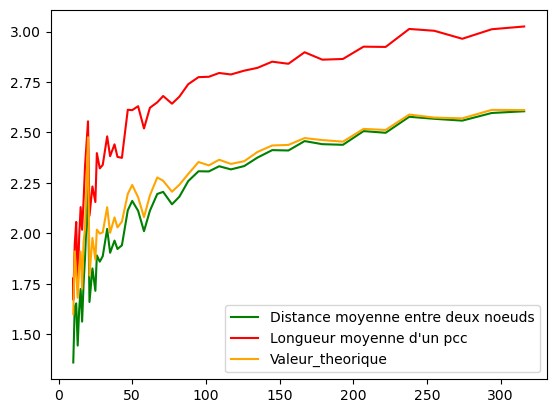

In [62]:
compare_dist_long(data_ER, valeur_theorique = valeur_theo_ER)

La valeur théorique ne colle pas avec la bonne courbe...

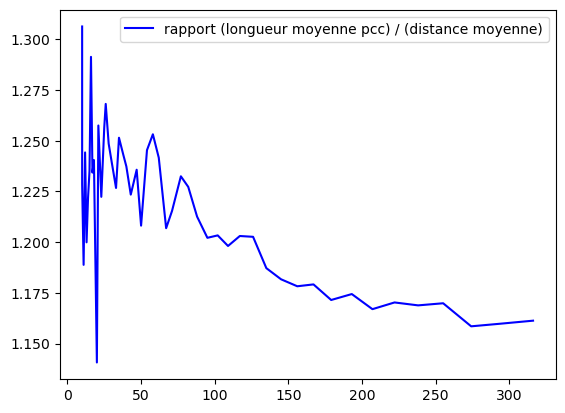

In [63]:
rapport_long_sur_dist(data_ER)

### Erdos Renyi en fonction de p

In [64]:
# Echantillon de nb_points graphes de n noeuds avec proba variant entre p_min et p_max
echant_ER_p, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 100)

In [65]:
data_ER_p = calcul_longueur_et_distance_moyenne(echant_ER_p)

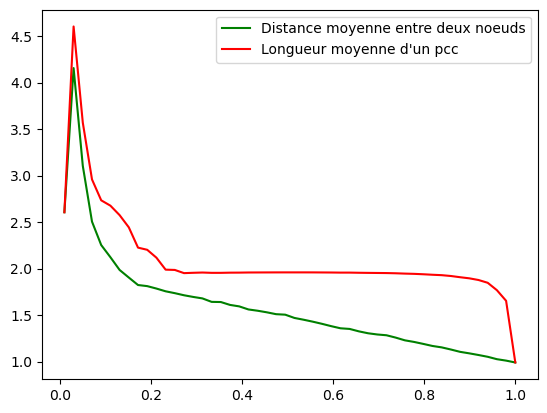

In [66]:
compare_dist_long(data_ER_p, abcisse = proba)

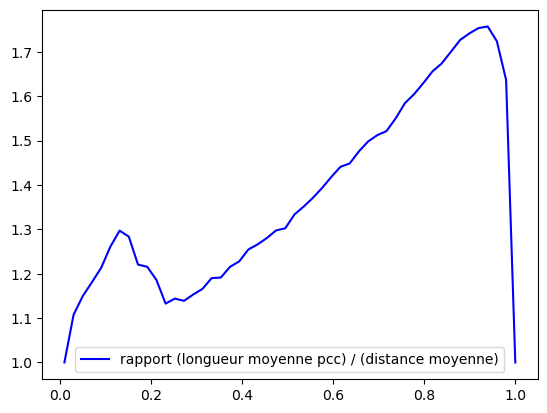

In [67]:
rapport_long_sur_dist(data_ER_p, abcisse = proba)

In [69]:
echant_ER_p_50, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 50)
echant_ER_p_75, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 75)
echant_ER_p_100, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 100)
echant_ER_p_125, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 125)
echant_ER_p_150, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 150)

In [70]:
data_ER_p_50 = calcul_longueur_et_distance_moyenne(echant_ER_p_50)
data_ER_p_75 = calcul_longueur_et_distance_moyenne(echant_ER_p_75)
data_ER_p_100 = calcul_longueur_et_distance_moyenne(echant_ER_p_100)
data_ER_p_125 = calcul_longueur_et_distance_moyenne(echant_ER_p_125)
data_ER_p_150 = calcul_longueur_et_distance_moyenne(echant_ER_p_150)

In [75]:
rapports_50 = calcul_rapport_lmoy_sur_dmoy(data_ER_p_50)
rapports_75 = calcul_rapport_lmoy_sur_dmoy(data_ER_p_75)
rapports_100 = calcul_rapport_lmoy_sur_dmoy(data_ER_p_100)
rapports_125 = calcul_rapport_lmoy_sur_dmoy(data_ER_p_125)
rapports_150 = calcul_rapport_lmoy_sur_dmoy(data_ER_p_150)

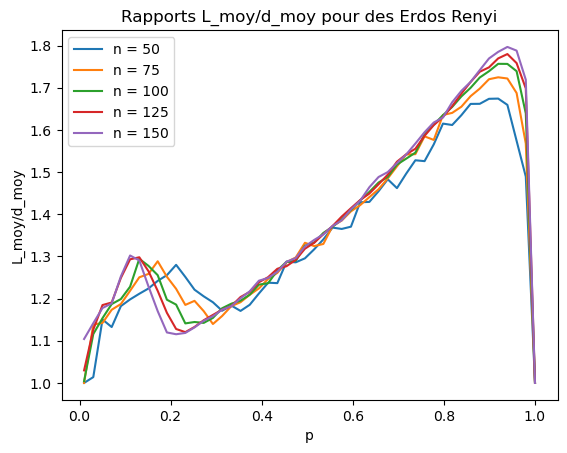

In [76]:
data = [rapports_50, rapports_75, rapports_100, rapports_125, rapports_150]
legendes = ["n = 50", "n = 75", "n = 100", "n = 125", "n = 150"]
dessin(proba, data, legendes, titre = "Rapports L_moy/d_moy pour des Erdos Renyi", nom_axe_x = "p", nom_axe_y = "L_moy/d_moy", logScale = False)

--> Essayer de trouver l'abscisse et la hauteur du second pic.

$N_d$ = nombre de PCC de longueur $d$. On a
- $\mathbb{E}(N_1) = n(n-1)p$
- $\mathbb{E}(N_2) = n(n-1)(n-2)p^2 (1-p)$
- $\mathbb{E}(N_d) \le d! \binom{n}{d} p^d (1-p)^{\frac{(d-1)(d-2)}{2}} (1 - p^2)^{(n-d) \frac{(d-2)(d-3)}{2}}$

$\underline{Objectif :}$ Trouver une minoration 

## 2.2. Grille $n \times n$